public score : 0.956484

private score : 0.960154

## Importing libraries : 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import product
from sklearn.preprocessing import LabelEncoder
import pickle

In [103]:
items = pd.read_csv('items.csv')
shops = pd.read_csv('shops.csv')
item_cat = pd.read_csv('item_categories.csv')
sales_train = pd.read_csv('sales_train_v2.csv')
test  = pd.read_csv('test.csv').set_index('ID')

## Deleting Outliers :

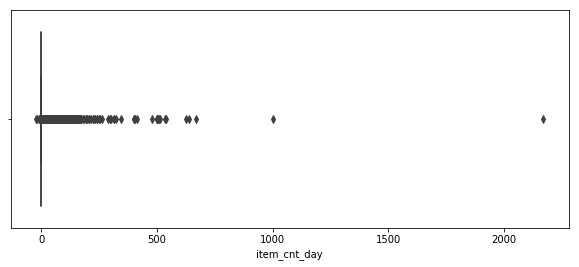

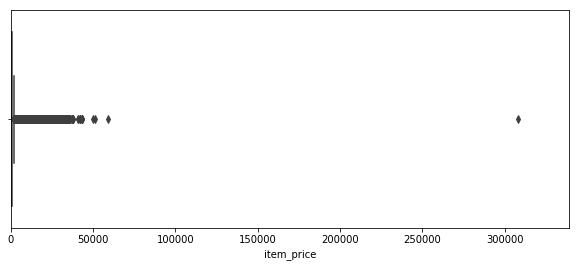

In [104]:
plt.figure(figsize=(10,4))
sns.boxplot(x=sales_train.item_cnt_day)

plt.figure(figsize=(10,4))
plt.xlim(sales_train.item_price.min(), sales_train.item_price.max()*1.1)
sns.boxplot(x=sales_train.item_price)

In [105]:
sales_train = sales_train[sales_train.item_price<250000]
sales_train = sales_train[sales_train.item_cnt_day<1000]

In [106]:
median = sales_train[(sales_train.shop_id==32)&(sales_train.item_id==2973)&(sales_train.date_block_num==4)&(sales_train.item_price>0)].item_price.median()
sales_train.loc[sales_train.item_price<0, 'item_price'] = median

## Extracting and encoding city name , category , subcategory : 

In [107]:
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
shops = shops[['shop_id','city_code']]

item_cat['split'] = item_cat['item_category_name'].str.split('-')
item_cat['type'] = item_cat['split'].map(lambda x: x[0].strip())
item_cat['type_code'] = LabelEncoder().fit_transform(item_cat['type'])
# if subtype is nan then type
item_cat['subtype'] = item_cat['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
item_cat['subtype_code'] = LabelEncoder().fit_transform(item_cat['subtype'])
item_cat = item_cat[['item_category_id','type_code', 'subtype_code']]

items.drop(['item_name'], axis=1, inplace=True)


## Here we have to generate missing rows and make the train set like the test set

In [108]:
matrix = []
cols = ['date_block_num','shop_id','item_id']
for i in range(34):
    sales = sales_train[sales_train.date_block_num==i]
    matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))
    
matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix.sort_values(cols,inplace=True)

Revenue Feature : 

In [109]:
sales_train['revenue'] = sales_train['item_price'] *  sales_train['item_cnt_day']

## Aggregation by month : 

In [110]:
group = sales_train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
group.columns = ['item_cnt_month']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=cols, how='left')
matrix['item_cnt_month'] = (matrix['item_cnt_month'].fillna(0).clip(0,20).astype(np.float16))

## We add the month for the test set (34), we concatinate matrix and test :

In [111]:
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)

matrix = pd.concat([matrix, test], ignore_index=True, sort=False, keys=cols)
matrix.fillna(0, inplace=True)

## Adding the city,item category , type and subtype features :

In [112]:
matrix = pd.merge(matrix, shops, on=['shop_id'], how='left')
matrix = pd.merge(matrix, items, on=['item_id'], how='left')
matrix = pd.merge(matrix, item_cat, on=['item_category_id'], how='left')
matrix['city_code'] = matrix['city_code'].astype(np.int8)
matrix['item_category_id'] = matrix['item_category_id'].astype(np.int8)
matrix['type_code'] = matrix['type_code'].astype(np.int8)
matrix['subtype_code'] = matrix['subtype_code'].astype(np.int8)

## Function to generate lags : 

In [113]:
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [114]:
matrix = lag_feature(matrix, [1,2,3,6,12], 'item_cnt_month')

## Generating mean encoded features : 

In [115]:
group = matrix.groupby(['date_block_num']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num'], how='left')
matrix['date_avg_item_cnt'] = matrix['date_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_avg_item_cnt')
matrix.drop(['date_avg_item_cnt'], axis=1, inplace=True)

In [116]:
group = matrix.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_cnt'] = matrix['date_item_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_item_avg_item_cnt')
matrix.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)

In [117]:
group = matrix.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_shop_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_avg_item_cnt'] = matrix['date_shop_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_shop_avg_item_cnt')
matrix.drop(['date_shop_avg_item_cnt'], axis=1, inplace=True)

In [118]:
group = matrix.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_cat_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_category_id'], how='left')
matrix['date_cat_avg_item_cnt'] = matrix['date_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_cat_avg_item_cnt')
matrix.drop(['date_cat_avg_item_cnt'], axis=1, inplace=True)

In [119]:
group = matrix.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_cat_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')
matrix['date_shop_cat_avg_item_cnt'] = matrix['date_shop_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_cat_avg_item_cnt')
matrix.drop(['date_shop_cat_avg_item_cnt'], axis=1, inplace=True)

In [120]:
group = matrix.groupby(['date_block_num', 'shop_id', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_type_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'type_code'], how='left')
matrix['date_shop_type_avg_item_cnt'] = matrix['date_shop_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_type_avg_item_cnt')
matrix.drop(['date_shop_type_avg_item_cnt'], axis=1, inplace=True)

In [121]:
group = matrix.groupby(['date_block_num', 'shop_id', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_subtype_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'subtype_code'], how='left')
matrix['date_shop_subtype_avg_item_cnt'] = matrix['date_shop_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_subtype_avg_item_cnt')
matrix.drop(['date_shop_subtype_avg_item_cnt'], axis=1, inplace=True)

In [122]:
group = matrix.groupby(['date_block_num', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'city_code'], how='left')
matrix['date_city_avg_item_cnt'] = matrix['date_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_city_avg_item_cnt')
matrix.drop(['date_city_avg_item_cnt'], axis=1, inplace=True)

In [123]:
group = matrix.groupby(['date_block_num', 'item_id', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'item_id', 'city_code'], how='left')
matrix['date_item_city_avg_item_cnt'] = matrix['date_item_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_item_city_avg_item_cnt')
matrix.drop(['date_item_city_avg_item_cnt'], axis=1, inplace=True)

In [124]:
group = matrix.groupby(['date_block_num', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_type_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'type_code'], how='left')
matrix['date_type_avg_item_cnt'] = matrix['date_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_type_avg_item_cnt')
matrix.drop(['date_type_avg_item_cnt'], axis=1, inplace=True)

In [125]:
group = matrix.groupby(['date_block_num', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_subtype_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'subtype_code'], how='left')
matrix['date_subtype_avg_item_cnt'] = matrix['date_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_subtype_avg_item_cnt')
matrix.drop(['date_subtype_avg_item_cnt'], axis=1, inplace=True)

## Generating the month feature from date_block_num : 

In [126]:
matrix['month'] = matrix['date_block_num'] % 12

## Dropping the first 12 months because of the lag generated and filling nulls : 

In [127]:
matrix = matrix[matrix.date_block_num > 11]

def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            if ('item_cnt' in col):
                df[col].fillna(0, inplace=True)         
    return df

matrix = fill_na(matrix)

In [128]:
matrix.to_pickle('data.pkl')

In [129]:
data = pd.read_pickle('data.pkl')

## Our test is the month 34 , our validation set are months 30,31,32,33 and our train set are remaining months

In [130]:
X_train = data[data.date_block_num < 30].drop(['item_cnt_month'], axis=1)
y_train = data[data.date_block_num < 30]['item_cnt_month']
X_valid = data[data.date_block_num.isin([30,31,32,33])].drop(['item_cnt_month'], axis=1)
y_valid = data[data.date_block_num.isin([30,31,32,33])]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

## Next for the model , I used lightgbm :

In [131]:
import lightgbm as lgb

In [132]:
model_lgb = lgb.LGBMRegressor(n_estimators=5000,learning_rate=0.3,random_state=0,early_stopping_rounds = 1000)

In [133]:
model_lgb.fit(X_train,y_train,eval_metric="rmse",eval_set=[(X_train,y_train),(X_valid,y_valid)])

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's l2: 1.14062	training's rmse: 1.068	valid_1's l2: 0.960567	valid_1's rmse: 0.980085
Training until validation scores don't improve for 1000 rounds.
[2]	training's l2: 0.982716	training's rmse: 0.99132	valid_1's l2: 0.847883	valid_1's rmse: 0.920806
[3]	training's l2: 0.896643	training's rmse: 0.946912	valid_1's l2: 0.787763	valid_1's rmse: 0.88756
[4]	training's l2: 0.847345	training's rmse: 0.920513	valid_1's l2: 0.757798	valid_1's rmse: 0.870516
[5]	training's l2: 0.817784	training's rmse: 0.904314	valid_1's l2: 0.735301	valid_1's rmse: 0.857497
[6]	training's l2: 0.798748	training's rmse: 0.893727	valid_1's l2: 0.724047	valid_1's rmse: 0.850909
[7]	training's l2: 0.782409	training's rmse: 0.884539	valid_1's l2: 0.71433	valid_1's rmse: 0.845181
[8]	training's l2: 0.772055	training's rmse: 0.878667	valid_1's l2: 0.708212	valid_1's rmse: 0.841553
[9]	training's l2: 0.763781	training's rmse: 0.873945	valid_1's l2: 0.705985	valid_1's rmse: 0.840229
[10]	training's l2: 0.755

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       early_stopping_rounds=1000, importance_type='split',
       learning_rate=0.3, max_depth=-1, min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=5000,
       n_jobs=-1, num_leaves=31, objective=None, random_state=0,
       reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=0)

In [134]:
y_test = model_lgb.predict(X_test).clip(0, 20)

c = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": y_test
})


In [137]:
from IPython.display import FileLink
def create_submission(submission_file, submission_name):
    submission_file.to_csv(submission_name+".csv",index=False)
    return FileLink(submission_name+".csv")

create_submission(submission_file=c, submission_name="cour")

/kaggle/working/cour.csv

In [135]:
pickle.dump(model_lgb, open("lightgbm.pickle", 'wb'))

In [136]:
FileLink("lightgbm.pickle")

/kaggle/working/lightgbm.pickle

In [3]:
df = pd.DataFrame({"postID":[30,30,40,50,50,60,60]})

In [4]:
df["postID"].value_counts()

30    2
60    2
50    2
40    1
Name: postID, dtype: int64

In [5]:
df["postID"].value_counts().index

Int64Index([30, 60, 50, 40], dtype='int64')

In [6]:
df["postID"].value_counts().values

array([2, 2, 2, 1], dtype=int64)